In [4]:
import numpy as np
import h5py
import lmdb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm,trange
from PIL import Image
from bs4 import BeautifulSoup
import requests
import re
import os
import glob
import pathlib
import time
import datetime
import json
from pathlib import Path
import pprint
from ip_basic import depth_map_utils
# for nyu, tum, diode
def center_crop(im, new_width=None, new_height=None):
    width, height = im.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    return im.crop((left, top, right, bottom))
def show_example(path='/hy-tmp/stage1/rgb_depth_large.mat', idx=0):
    with  h5py.File(path,'r') as t:
        rgb = t['rgb']
        depth = t['depth']
        print(rgb.shape)
        rgbi = rgb[idx]
        depthi = depth[idx]
    fig=plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    xx = np.arange(0,256)
    yy = np.arange(0,256)
    X, Y = np.meshgrid(xx, yy)
    ax1.plot_surface(X,Y,depthi.squeeze(),cmap='rainbow')
    plt.show()
    plt.close()

    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(rgbi)
    ax2.imshow(depthi)
    plt.show()
    plt.close()
# for tum
def depth_completion(depthi, loop=2):
    '''ip_basic depth completion
    '''
    fill_type = 'fast'
    extrapolate = True
    blur_type = 'bilateral'
    for _ in range(loop):
        if fill_type == 'fast':
            depthi = depth_map_utils.fill_in_fast(
                depthi, extrapolate=extrapolate, blur_type=blur_type)
        elif fill_type == 'multiscale':
            depthi, process_dict = depth_map_utils.fill_in_multiscale(
                depthi, extrapolate=extrapolate, blur_type=blur_type,
                show_process=False)
    return depthi
def get_timestamp(v):
    f = v.split("/")[-1]
    stamp = f.replace(".png","")
    return float(stamp)
def align_rgb_depth(rgbs, depths, bi=True):
    '''Align two sequeces by timestamps in the filenames
    Use rgb as base
    '''
    if len(rgbs)==len(depths):
        return rgbs, depths
    res_rgbs = rgbs
    res_depths = []
    for i, v in enumerate(res_rgbs):
        target_stamp = get_timestamp(v)
        current_d = depths[0]
        if bi:
            # bi-search
            left = 0
            right = len(depths)-1
            while left<=right:
                mid = (left+right)//2
                now_stamp = get_timestamp(depths[mid])
                if now_stamp==target_stamp:
                    left=mid
                    right=mid-1
                elif now_stamp>target_stamp:
                    right = mid-1
                else:
                    left = mid+1
            if left==0:
                current_d = depths[left]
            elif right==len(depths)-1:
                current_d = depths[right]
            else:
                current_d = depths[left] if abs(get_timestamp(depths[left])-target_stamp)<abs(get_timestamp(depths[left-1])-target_stamp) else depths[left-1]
        else:
            current_min = 100000000
            for j, p in enumerate(depths):
                current_stamp = get_timestamp(p)
                if abs(target_stamp-current_stamp)<current_min:
                    current_min =  abs(target_stamp-current_stamp)
                    current_d = p
        res_depths.append(current_d)
    assert len(res_rgbs)==len(res_depths)
    return res_rgbs, res_depths

## Split episode and panorama

In [56]:
# Adapted from https://github.com/fuenwang/Equirec2Perspec

import os
import sys
import cv2
import numpy as np
import math

class Equirectangular:
    def __init__(self, img):
        self._img = img
        [self._height, self._width, _] = self._img.shape
        #cp = self._img.copy()  
        #w = self._width
        #self._img[:, :w/8, :] = cp[:, 7*w/8:, :]
        #self._img[:, w/8:, :] = cp[:, :7*w/8, :]
    

    def GetPerspective(self, FOV, THETA, PHI, height, width, RADIUS = 128):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        equ_h = self._height
        equ_w = self._width
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0     
        
        hFOV = math.radians(FOV)
        wFOV = 2*math.atan(float(width)/height * np.tan(hFOV / 2.0))

        c_x = (width - 1) / 2.0
        c_y = (height - 1) / 2.0

        wangle = (math.pi - wFOV) / 2.0
        w_len = 2 * RADIUS * np.sin(wFOV / 2.0) / np.sin(wangle)
        w_interval = w_len / (width - 1)

        hangle = (math.pi - hFOV) / 2.0
        h_len = 2 * RADIUS * np.sin(hFOV / 2.0) / np.sin(hangle)
        h_interval = h_len / (height - 1)
        x_map = np.zeros([height, width], np.float32) + RADIUS
        y_map = np.tile((np.arange(0, width) - c_x) * w_interval, [height, 1])
        z_map = -np.tile((np.arange(0, height) - c_y) * h_interval, [width, 1]).T
        D = np.sqrt(x_map**2 + y_map**2 + z_map**2)
        xyz = np.zeros([height, width, 3], float)
        xyz[:, :, 0] = (RADIUS / D * x_map)[:, :]
        xyz[:, :, 1] = (RADIUS / D * y_map)[:, :]
        xyz[:, :, 2] = (RADIUS / D * z_map)[:, :]
        
        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        z_axis = np.array([0.0, 0.0, 1.0], np.float32)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2] / RADIUS)
        lon = np.zeros([height * width], float)
        theta = np.arctan(xyz[:, 1] / xyz[:, 0])
        idx1 = xyz[:, 0] > 0
        idx2 = xyz[:, 1] > 0

        idx3 = ((1 - idx1) * idx2).astype(bool)
        idx4 = ((1 - idx1) * (1 - idx2)).astype(bool)
        
        lon[idx1] = theta[idx1]
        lon[idx3] = theta[idx3] + np.pi
        lon[idx4] = theta[idx4] - np.pi

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180
        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90 * equ_cy + equ_cy
        #for x in range(width):
        #    for y in range(height):
        #        cv2.circle(self._img, (int(lon[y, x]), int(lat[y, x])), 1, (0, 255, 0))
        #return self._img 
    
        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
        return persp

"""从全景图得到子图的代码"""
# Simulator image parameters
VIEWPOINT_SIZE = 36
FEATURE_SIZE = 2048

# WIDTH = 480
# HEIGHT = 480
# VFOV = 90
# HFOV = 90  # makes a VFOV of 60

SCANS = ['TJARKatROOM', 'TJARKmeet302', 'TJARKmeet305', 'TJARKmeeting603']

def equirectangular_to_perspective(image, save_path, viewpoint):
    ''' Convert an equirectangular pano to 36 perspective images used by the VLN
        agent. Construct it with 12 heading 
        viewpoints and 3 elevation viewpoints, starting with the heading that is
        directly in front. The agent works better if these views are aligned to the
        building. '''
    equi = Equirectangular(image)  # RGB shape of [H, W, 3]
    im_width = 480
    im_height = 480
    vfov = 60

    # heading, elevation. Here, heading is defined from the x-axis, and turning right 
    # is positive. This matches the matterport sim, but opposite to ros
    he = np.zeros((3, 12, 2), dtype=np.float32)

    
    # for i,v_deg in enumerate(range(0, 30, 30)):
        # 注意！ 这个-150°是和全景图在MP3D模拟器中的航向角挂钩的，MP3D中的航向角=150 - ros_heading
    v_deg = 0
    i = 0
    for j,u_deg in enumerate(range(-180, 180, 90)):
        # Negate heading since for e2p turning right is positive, opposite in ros
        head = -math.radians(u_deg)
        he[i,j] = [head + 2*math.pi if head<0 else head, math.radians(v_deg)]
        p_im = equi.GetPerspective(vfov, u_deg, v_deg, im_height, im_width)
        cv2.imwrite(os.path.join(save_path, f"{viewpoint}_{str(12*i+j)}.jpg"), p_im)
           
def roll_image(image, pano_heading_rad):
    """
    input: 
        image: theta相机获得的全景图,机器人坐标系
        pano_heading_rad: 机器人朝向
    output:
        image: 将全景图转到地图坐标系0方向
    """
    x_axis = 1 # width
    roll_pixels = -int(pano_heading_rad / (math.pi * 2) * image.shape[x_axis])
    rolled_image = np.roll(image, roll_pixels, axis=x_axis)
    return rolled_image           

In [57]:
raw_data_path = "/root/autodl-tmp/r2r/"
dataset_path = "/root/autodl-tmp/r2r/tjark_r2r_all.json"
new_data_path = "/root/autodl-tmp/r2r_split/"
os.makedirs(new_data_path, exist_ok=True)
with open(dataset_path, "r") as f:
    tjark_r2r = json.loads(f.read())
for i, ep in tqdm(enumerate(tjark_r2r)):
    scan = ep["scan"]+"_imgs"
    path = ep["path"]
    inst = ep["instructions"][0]

    os.makedirs(os.path.join(new_data_path, str(i)), exist_ok=True)
    inst_path = os.path.join(new_data_path, str(i), "instruction.txt")
    with open(inst_path,"w") as f:
        f.write(inst)

    for j,vp in enumerate(path):
        img_path = os.path.join(raw_data_path, scan, vp+"_equirectangular.jpg")
        img = cv2.imread(img_path)
        os.makedirs(os.path.join(new_data_path, str(i), "rgb"), exist_ok=True)
        equirectangular_to_perspective(img, os.path.join(new_data_path, str(i), "rgb"), j)

0it [00:00, ?it/s]

In [58]:
ep

{'scan': 'TJARKjirenlou_night',
 'path': ['0y2urprvgqoko7ndsho5k64uk6ztovct',
  'odocgs7gdw01gr8gi1e3ugm12vw8rtrt',
  'pogdnwafltpil7vp0fwzgux6blcehc10',
  'ehvg4i1zoaf1ngye62exswwxhacgf5ra',
  'wbzgi90qeprorulk4vp5gk4hwp6c3lh3',
  'gwikcem025hd4p2d3fq5h4zwaof9rt0u',
  'eey023eprkn3hm4kbh7x36wp7c0tiwa8',
  'eurzc2bcumco2xoyqwg2orylbqegpyyg',
  '7v2m6buxe4lx2f80w8m5g8hd0x2b8va1'],
 'instructions': ['Turn left toward the basketball and glass door, pass the white platform with books, tablets and coffee cups, turn right in front of the glass door, exit the glass door, there is a black chair in front of you, turn left, and walk down the corridor. Pass the black chair, the front door of the restaurant, the wheelbarrow, the back door of the restaurant and the cardboard box to reach the door of the storage room. Turn left through the glass door and enter the storeroom and stop.'],
 'heading': 1.5882494984696853,
 'distance': 16.487282021505766,
 'path_id': 65}

## Depth estimation

In [59]:

# timm==0.6.7
# 
import numpy as np
from torchvision.transforms import ToTensor
from PIL import Image
import torch

from torchvision import transforms

import os
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

resize = transforms.Resize([384, 512])
scale = 4.0

test_image = 'C:/Users/tangjg/Desktop/08c774f20c984008882da2b8547850eb_skybox1_sami.jpg'

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cpu":
    print("WARNING: Running on CPU. This will be slow. Check your CUDA installation.")


def load_model():
    # torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True) 
    model = torch.hub.load("isl-org/ZoeDepth", "ZoeD_NK", pretrained=True)
    model.to(DEVICE)
    model.eval()
    return model

def InferImage(image_file):
    image = Image.open(image_file)
    origin_size = image.size
    img = ToTensor()(image).to(DEVICE).unsqueeze_(0)
    img.to(DEVICE)
    
    model = load_model()
    model.cuda()
    model.eval()
    
    with torch.no_grad():
        out = model(img)
        out_img = Image.fromarray(out['metric_depth'].squeeze().cpu().numpy())
        out_img.resize(origin_size, Image.ANTIALIAS)
        out_img.show()

model = load_model()
def inferImageAndCompare(idx, model):
    rgb_path = f'/root/EvoEnc/r2r_split/{idx}/rgb'
    out_path = f'/root/EvoEnc/r2r_split/{idx}/depth'
    os.makedirs(out_path, exist_ok=True)

    rgb_images = os.listdir(rgb_path)
    for rgb_img in rgb_images:
        path = os.path.join(rgb_path, rgb_img)
        
        image = Image.open(path)
        origin_size = image.size
        origin_max = np.array(image).max()
        
        depth_pil = model.infer_pil(image, output_type='pil')
        
        # resize并进行scale缩放，与GT尺度相同
        depth_pil = depth_pil.resize(origin_size, Image.LANCZOS)
        out_arr = np.array(depth_pil)
        out_arr = out_arr*scale # multiplied by 4, assume it is accurate absolute depth*1000
        depth_pil = Image.fromarray(out_arr.astype(np.uint16))
        
        depth_pil.save(os.path.join(out_path, rgb_img.replace(".jpg",".png")))
for i in tqdm(range(408)):
    inferImageAndCompare(i, model)

Using cache found in /root/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


  0%|          | 0/408 [00:00<?, ?it/s]

## To HDF5

In [2]:
import copy
import gzip
import itertools
import json
import pickle
import random
import re
import threading
import time
from collections import Counter
import glob

import h5py
import clip
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
from nltk.tokenize import PunktSentenceTokenizer
from numba import jit
from PIL import Image
from tqdm.notebook import tqdm
import pickle
import pathlib
from nltk.tokenize import PunktSentenceTokenizer
random.seed(25)
np.random.seed(25)
def instruction_cut_clip(episodes, append_dot=False, keep_subs=True, refine=False, split_func=None, lower_all=False):
    """
    Params:
        episodes: a dataset list, [{"instruction_text":""}]
        append_dot: whether to add a "." at the end of sub-instructions
        keep_subs: whether to keep sub-instruction text after processing
        refine: whether to use proposed refine processing
        split_func: the function used to cut instructions, default is `nltk.sent_tokenize`
        lower_all: whether to lower all characters in sub-instructions.
    Return:
        train_data with "sub_instruction_tokens" and "sub_instruction"
    """
    if split_func is None:
        split_func = nltk.sent_tokenize
    print(split_func)
    train_data = copy.deepcopy(episodes)
    # pre process
    char_pattern = re.compile(r"[a-zA-Z]")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction_text"]
        inst = inst.strip()
        start_idx = 0
        while not char_pattern.search(inst[start_idx]):
            start_idx += 1
        inst = inst[start_idx:]
        if lower_all:
            inst = inst.lower()
        train_data[i]["instruction_text"] = inst.replace("...", ".").replace("..", ".").replace(".",". ").replace("  ", " ")
    
    # cut by nltk
    pattern = re.compile(r"\r\n")
    for i, item in enumerate(tqdm(train_data)):
        inst = item["instruction_text"]
        res = []
        now = pattern.split(inst)
        for v in now:
            res.extend(split_func(v))
        train_data[i]["sub_instruction"] = [piece.strip() for piece in res if piece.strip()]
    # refine
    if refine:
        punctuation_list = [",", "."]
        char_pattern = re.compile(r"[a-zA-Z]+")
        def judge_verb(word):
            const_verbs = ["wait", "turn", "walk", "stop"]
            if "VB" in word[1]:
                return True
            if word[0] in const_verbs:
                return True
            return False
        for i, item in enumerate(tqdm(train_data)):
            new_sub = []
            for k, piece in enumerate(item["sub_instruction"]):
                word_list = nltk.pos_tag(nltk.word_tokenize(piece))
                tmp = ""
                for x, word in enumerate(word_list):
                    if (word[0].lower()=="and" or word[0]=="," or word[0].lower()=="then") and (x+1<len(word_list) and judge_verb(word_list[x+1])):
                        if tmp and char_pattern.search(tmp):
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                            
                    elif (word[0]=="and" or word[0]==",") and (x+1<len(word_list) and word_list[x+1][0]=="then"):
                        if tmp:
                            new_sub.append(tmp)
                        if word[0].lower()=="and" or word[0].lower()=="then":
                            tmp = word[0]
                        else:
                            tmp = ""
                    else:
                        if not tmp or word[0] in punctuation_list:
                            tmp+=word[0]
                        else:
                            tmp+=(" "+word[0])
                if tmp:
                    new_sub.append(tmp)
            train_data[i]["sub_instruction"] = new_sub
    
    # post process and generate tokens
    char_pattern = re.compile(r"[a-zA-Z]")
    max_len = 0
    pad_index = 0
    pad_len = 86 # 0.09%
    sub_pad_len = 77 # 0.05%
    sub_num = 12 # 0.04%
    useless_sub = [pad_index]*sub_pad_len
    sub_split_index = -1
    for i, item in enumerate(tqdm(train_data)):
        tokens_all = []
        tokens_split = []
        for k, piece in enumerate(item["sub_instruction"]):
            piece = piece.strip()
            assert piece
            idx = len(piece)-1
            while idx>=0 and piece[idx] in [".", ","]:
                idx -= 1
            if append_dot:
                piece = piece[0:(idx+1)]+"."
            else:
                piece = piece[0:(idx+1)]
            piece = piece.replace("``", "\"").replace("''", "\"")
            train_data[i]["sub_instruction"][k] = piece
            piece_tokens = clip.tokenize(piece, truncate=True).squeeze(0).tolist()
            tokens_split.append(piece_tokens)
        if len(tokens_split)>sub_num:
            tokens_split = tokens_split[0:sub_num]
        tokens_split.extend([useless_sub]*(sub_num-len(tokens_split)))
        
        train_data[i]["instruction_tokens"] = clip.tokenize(item["instruction_text"], truncate=True, context_length=77).squeeze(0).tolist()
        train_data[i]["sub_instruction_tokens"] = tokens_split
        if not keep_subs:
            del item["sub_instruction"]
    return train_data

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
def random_chunks(lst, left, right):
    """Yield successive n-sized chunks from lst."""
    i = 0
    n = len(lst)
    while i<n:
        k = random.randint(left,right)
        yield lst[i:min(i+k, n)]
        i += k

In [61]:

MIN_DEPTH = 0
MAX_DEPTH = 10
CROP_SIZE = 768
RGB_SIZE = 224
DEPTH_SIZE = 256
SUB_LEN = 12
INST_LEN = 77
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
os.makedirs("/root/autodl-tmp/realscene", exist_ok=True)
real_folder = "/root/autodl-tmp/realscene"
with h5py.File(os.path.join(real_folder, "rgb.mat"),'a') as t_rgb, h5py.File(os.path.join(real_folder, "depth.mat"),'a') as t_depth, h5py.File(os.path.join(real_folder, "inst.mat"),'a') as t_inst, h5py.File(os.path.join(real_folder, "sub.mat"),'a') as t_sub:
    if "rgb" in t_rgb:
        del t_rgb["rgb"]
    if "depth" in t_depth:
        del t_depth["depth"]
    if "instructions" in t_inst:
        del t_inst["instructions"]
    if "sub_instructions" in t_sub:
        del t_sub["sub_instructions"]
    target_rgb = t_rgb.create_dataset("rgb", shape=(0, RGB_SIZE, RGB_SIZE, 3), maxshape=(None, RGB_SIZE, RGB_SIZE, 3), dtype=np.uint8)
    target_depth = t_depth.create_dataset("depth", shape=(0, DEPTH_SIZE, DEPTH_SIZE, 1), maxshape=(None, DEPTH_SIZE, DEPTH_SIZE, 1), dtype=np.float32)
    target_inst = t_inst.create_dataset("instructions", shape=(0, INST_LEN), maxshape=(None, INST_LEN), dtype=np.int32)
    target_sub = t_sub.create_dataset("sub_instructions", shape=(0, SUB_LEN, INST_LEN), maxshape=(None, SUB_LEN, INST_LEN), dtype=np.int32)

    rgbs = []
    depths = []
    insts = []
    subs = []
    for ep_id in range(408):
        episode_folder = "/root/autodl-tmp/r2r_split/{}".format(ep_id)
        with open(os.path.join(episode_folder, "instruction.txt"), "r") as f:
            inst = f.read()
        rgbs.extend(sorted(glob.glob(os.path.join(episode_folder, "rgb","*"))))
        depths.extend(sorted(glob.glob(os.path.join(episode_folder, "depth","*"))))
        assert len(rgbs)==len(depths)
        insts.extend([inst]*len(sorted(glob.glob(os.path.join(episode_folder, "rgb","*")))))
    instructions = [{"instruction_text": v} for v in insts]
    sub_data = instruction_cut_clip(instructions, refine=True, append_dot=False, split_func=nltk.sent_tokenize)
    assert len(instructions)==len(sub_data)
    for i in range(len(rgbs)):
        
        rgbi = Image.open(rgbs[i]).convert("RGB")
        CROP_SIZE = min(rgbi.size)
        rgbi = center_crop(rgbi, CROP_SIZE, CROP_SIZE)
        rgbi = rgbi.resize((RGB_SIZE,RGB_SIZE),resample=Image.Resampling.LANCZOS)
        rgbi = np.array(rgbi)
        target_rgb.resize(target_rgb.shape[0]+1, axis=0)
        target_rgb[-1:] = rgbi

        depthi = Image.open(depths[i])
        CROP_SIZE = min(depthi.size)
        depthi = np.array(depthi).astype('float32')/1000.0
        if depthi.min()==0:
            depthi = depth_completion(depthi)
        depthi = np.clip(depthi, MIN_DEPTH, MAX_DEPTH)
        depthi = (depthi - MIN_DEPTH) / (
            MAX_DEPTH - MIN_DEPTH
        )
        depthi = Image.fromarray(depthi)
        depthi = center_crop(depthi, CROP_SIZE, CROP_SIZE)
        depthi = depthi.resize((DEPTH_SIZE,DEPTH_SIZE),resample=Image.Resampling.LANCZOS)
        depthi = np.array(depthi)
        depthi = np.clip(depthi, 0.0, 1.0)
        depthi = np.expand_dims(depthi, axis=2)
        target_depth.resize(target_depth.shape[0]+1, axis=0)
        target_depth[-1:] = depthi

        insti = clip.tokenize(insts[i], truncate=True, context_length=77).squeeze(0).numpy()
        target_inst.resize(target_inst.shape[0]+1, axis=0)
        target_inst[-1:] = insti

        subi = sub_data[i]["sub_instruction_tokens"]
        target_sub.resize(target_sub.shape[0]+1, axis=0)
        target_sub[-1:] = np.array(subi, dtype=np.int32)


<function sent_tokenize at 0x7f0e3c1a2a60>


  0%|          | 0/8772 [00:00<?, ?it/s]

  0%|          | 0/8772 [00:00<?, ?it/s]

  0%|          | 0/8772 [00:00<?, ?it/s]

  0%|          | 0/8772 [00:00<?, ?it/s]

(8772, 224, 224, 3)
(8772, 256, 256, 1)
(8772, 77)
(8772, 12, 77)


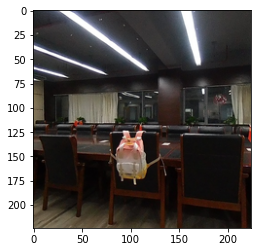

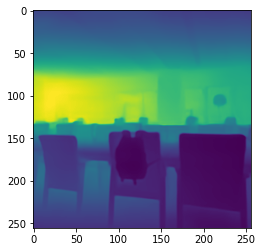

In [62]:
import matplotlib.pyplot as plt
with h5py.File(os.path.join(real_folder, "rgb.mat"),'r') as t:
    print(t["rgb"].shape)
    plt.figure()
    plt.imshow(t["rgb"][1000])
with h5py.File(os.path.join(real_folder, "depth.mat"),'r') as t:
    print(t["depth"].shape)
    plt.figure()
    plt.imshow(t["depth"][1000].astype(float))
with h5py.File(os.path.join(real_folder, "inst.mat"),'r') as t:
    print(t["instructions"].shape)
with h5py.File(os.path.join(real_folder, "sub.mat"),'r') as t:
    print(t["sub_instructions"].shape)

In [63]:
raw_data_path = "/root/autodl-tmp/r2r/"
dataset_path = "/root/autodl-tmp/r2r/tjark_r2r_all.json"
new_data_path = "/root/autodl-tmp/r2r_split/"
os.makedirs(new_data_path, exist_ok=True)
with open(dataset_path, "r") as f:
    tjark_r2r = json.loads(f.read())

In [64]:
insts = []
for v in tjark_r2r:
    if v["scan"]=="TJARKmeeting603":
        print(v)
        insts.append(v["instructions"][0])

{'scan': 'TJARKmeeting603', 'path': ['bmh8fcimgqza8myop8gs7thkxg63bzg6', 'hmamoxus1vvt2giaxm4nucsx0lgb45gi', '1agnt61o8tcsdkw4cbcx7s8qq2mzvgp0', 'bfmgkcm45brdphs9imfsr7y10fr0q39l'], 'instructions': ['Turn left, go straight to the door, turn right, go straight along the conference room table, walk past the whiteboard and stop.'], 'heading': 3.1371157841229316, 'distance': 9.39962723319736, 'path_id': 55}
{'scan': 'TJARKmeeting603', 'path': ['pzn8hrw4zcfuoh87y350e729iueufem9', 'gzsrgso8fwebuz8dicmctozwvggk157f', 'wifi7x8fe2bg0y8v2nraa2xg7b5e18mr', '0ie7iznal42uz47avqry3g24gag7l63v'], 'instructions': ['Turn right and face the corridor, go to the intersection, turn left, enter the first door on your left, and stop.'], 'heading': 0.6194343807680607, 'distance': 12.427497859294148, 'path_id': 59}
{'scan': 'TJARKmeeting603', 'path': ['unprk09smol1w5v52eliul2hs7bgfkgi', '0weeb6ug4gsfomg8232v6ugdz7y0w5yz', 'hi8urh7yah8nwzklwr15stezk0lzqux4', '0ie7iznal42uz47avqry3g24gag7l63v'], 'instructions': 

In [65]:
min_len = 100000000000
for v in insts:
    if len(v)<min_len:
        min_len = len(v)
        print(v)

Turn left, go straight to the door, turn right, go straight along the conference room table, walk past the whiteboard and stop.
Turn right and face the corridor, go to the intersection, turn left, enter the first door on your left, and stop.


In [66]:

dep = Image.open("/root/EvoEnc/r2r_split/399/depth/3_3.png")
dep = np.array(dep).astype(float)/10000.0
dep = np.clip(dep, 0, 1)
dep = np.round(dep*255).astype(np.uint8)
dep = Image.fromarray(dep)
dep.save("tmp.jpg")

In [ ]:
all_eval = {}
import random
for i in range(250):
    seed = random.randint(0,200000)
    os.system("cd /root/EvoEnc; python run.py --run-type eval --exp-config evoenc/config/evoenc_realscene.yaml TASK_CONFIG.SEED {}".format(seed))
    with open("/root/EvoEnc/data/checkpoints/evoenc_p2/evals/stats_ckpt_0_realscene.json", "r") as f:
        now_eval = json.loads(f.read())
    all_eval[seed] = now_eval
with open("all_eval.json", "w") as f:
    f.write(json.dumps(all_eval, indent=2))

In [2]:
import json
with open("all_eval.json", "r") as f:
    all_eval = json.loads(f.read())
min_loss_rec = [100000, {}]
min_loss_mean = [100000, {}]
max_acc_inner = [-1, {}]
max_acc_outer = [-1, {}]
for v in all_eval.values():
    if v["losses"]["loss_rec"]<min_loss_rec[0]:
        min_loss_rec = [v["losses"]["loss_rec"], v]
    if v["losses"]["loss_mean"]<min_loss_mean[0]:
        min_loss_mean = [v["losses"]["loss_mean"], v]
    if v["accuracy"]["inner_v"]>max_acc_inner[0]:
        max_acc_inner = [v["accuracy"]["inner_v"], v]
    if v["accuracy"]["outer"]>max_acc_outer[0]:
        max_acc_outer = [v["accuracy"]["outer"], v]

In [5]:
from pprint import pprint
pprint([min_loss_rec, min_loss_mean, max_acc_inner, max_acc_outer])

[[1.0891839265823364,
  {'accuracy': {'inner_l': 0.9465344548225403,
                'inner_v': 0.9467624425888062,
                'outer': 0.7078203558921814},
   'f1_socre': {'inner_l': 0.9584404230117798,
                'inner_v': 0.9585072994232178,
                'outer': 0.37533509731292725},
   'losses': {'loss_inner': 0.5433290600776672,
              'loss_mean': 0.07010027766227722,
              'loss_outer': 0.7262082695960999,
              'loss_rec': 1.0891839265823364}}],
 [0.06986289471387863,
  {'accuracy': {'inner_l': 0.9506384134292603,
                'inner_v': 0.9493843913078308,
                'outer': 0.6902644634246826},
   'f1_socre': {'inner_l': 0.9618938565254211,
                'inner_v': 0.9608051180839539,
                'outer': 0.36740392446517944},
   'losses': {'loss_inner': 0.5198701024055481,
              'loss_mean': 0.06986289471387863,
              'loss_outer': 0.755111575126648,
              'loss_rec': 1.1328682899475098}}],
 [0.9545

# Apply the whole model to real world

RGB denoise

In [10]:
from pathlib import Path

# timm==0.6.7
import numpy as np
from torchvision.transforms import ToTensor
from PIL import Image
import torch
import cv2
from torchvision import transforms
from tqdm.notebook import tqdm
import math
import sys

def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        # print("Lowval: ", low_val)
        # print("Highval: ", high_val)

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)
DATA_FOLDER = Path("/root/autodl-tmp/vlntj-ce")
rgb_path = DATA_FOLDER 
for rgb_img in tqdm(list(rgb_path.glob("*/rgb/*.png"))):
    rgb = cv2.imread(str(rgb_img))
    rgb = simplest_cb(rgb, 1)
    cv2.imwrite(str(rgb_img), rgb)

  0%|          | 0/536 [00:00<?, ?it/s]

Generate depth

In [11]:
from pathlib import Path

# timm==0.6.7
import numpy as np
from torchvision.transforms import ToTensor
from PIL import Image
import torch

from torchvision import transforms

import os
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

DATA_FOLDER = Path("/root/autodl-tmp/vlntj-ce")
EPISODE_NUM = 13
resize = transforms.Resize([384, 512])
scale = 3.98

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cpu":
    print("WARNING: Running on CPU. This will be slow. Check your CUDA installation.")


def load_model():
    # torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True) 
    model = torch.hub.load("isl-org/ZoeDepth", "ZoeD_NK", pretrained=True)
    model.to(DEVICE)
    model.eval()
    return model

def InferImage(image_file):
    image = Image.open(image_file)
    origin_size = image.size
    img = ToTensor()(image).to(DEVICE).unsqueeze_(0)
    img.to(DEVICE)
    
    model = load_model()
    model.cuda()
    model.eval()
    
    with torch.no_grad():
        out = model(img)
        out_img = Image.fromarray(out['metric_depth'].squeeze().cpu().numpy())
        out_img.resize(origin_size, Image.ANTIALIAS)
        out_img.show()

model = load_model()
def inferImageAndCompare(idx, model):
    rgb_path = DATA_FOLDER / f'{idx}/rgb'
    out_path = DATA_FOLDER / f'{idx}/depth'
    os.makedirs(out_path, exist_ok=True)

    rgb_images = os.listdir(rgb_path)
    for rgb_img in rgb_images:
        path = os.path.join(rgb_path, rgb_img)
        
        image = Image.open(path).convert("RGB")
        origin_size = image.size
        origin_max = np.array(image).max()
        
        depth_pil = model.infer_pil(image, output_type='pil')
        
        # resize并进行scale缩放，与GT尺度相同
        depth_pil = depth_pil.resize(origin_size, Image.LANCZOS)
        out_arr = np.array(depth_pil)
        out_arr = out_arr*scale # multiplied by 4, assume it is accurate absolute depth*1000
        depth_pil = Image.fromarray(out_arr.astype(np.uint16))
        
        depth_pil.save(os.path.join(out_path, rgb_img.replace(".jpg",".png")))
for i in tqdm(range(EPISODE_NUM)):
    idx = i
    rgb_path = DATA_FOLDER / f'{idx}/rgb'
    out_path = DATA_FOLDER / f'{idx}/depth'
    os.makedirs(out_path, exist_ok=True)

    rgb_images = os.listdir(rgb_path)
    for rgb_img in rgb_images:
        path = os.path.join(rgb_path, rgb_img)
        
        image = Image.open(path).convert("RGB")
        origin_size = image.size
        origin_max = np.array(image).max()
        
        depth_pil = model.infer_pil(image, output_type='pil')
        # resize并进行scale缩放，与GT尺度相同
        depth_pil = depth_pil.resize(origin_size)
        out_arr = np.array(depth_pil)
        out_arr = out_arr*scale # multiplied by 4, assume it is accurate absolute depth*1000
        depth_pil = Image.fromarray(out_arr.astype(np.uint16))
        
        depth_pil.save(os.path.join(out_path, rgb_img.replace(".jpg",".png")))

Using cache found in /root/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_NK.pt
Loaded successfully


  0%|          | 0/13 [00:00<?, ?it/s]

RGB resize

In [12]:
from pathlib import Path

# timm==0.6.7
import numpy as np
from torchvision.transforms import ToTensor
from PIL import Image
import torch

from torchvision import transforms
def center_crop(im, new_width=None, new_height=None):
    width, height = im.size   # Get dimensions
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    return im.crop((left, top, right, bottom))
DATA_FOLDER = Path("/root/autodl-tmp/vlntj-ce")
rgb_path = DATA_FOLDER 
RGB_SIZE = 224
DEPTH_SIZE = 256
for rgb_img in tqdm(list(rgb_path.glob("*/rgb/*.png"))):
    rgb = Image.open(rgb_img)
    size = rgb.size
    crop_size = min(size)
    rgb = center_crop(rgb, crop_size, crop_size)
    rgb = rgb.resize((RGB_SIZE,RGB_SIZE),resample=Image.LANCZOS)
    rgb.save(rgb_img)
    
    depth_img = str(rgb_img).replace("/rgb/","/depth/")
    depth = Image.open(depth_img)
    size = depth.size
    crop_size = min(size)
    depth = center_crop(depth, crop_size, crop_size)
    depth = depth.resize((DEPTH_SIZE,DEPTH_SIZE))
    depth.save(depth_img)


  0%|          | 0/536 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

3796.0


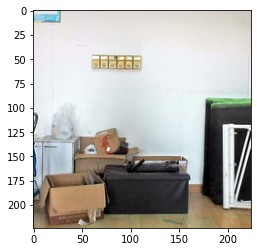

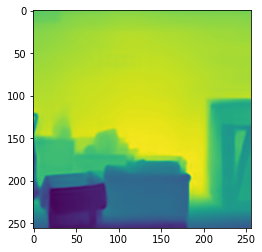

3622.0


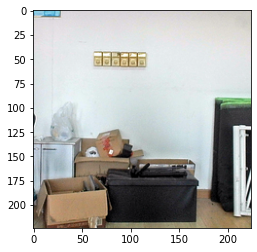

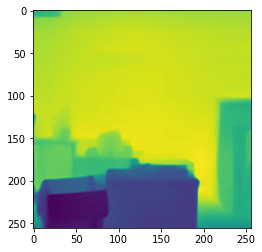

5166.0


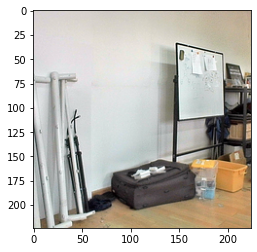

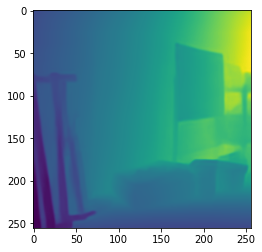

8691.0


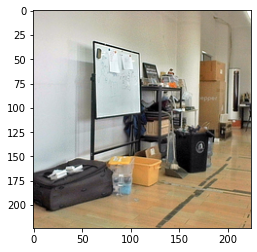

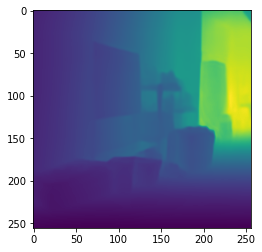

8649.0


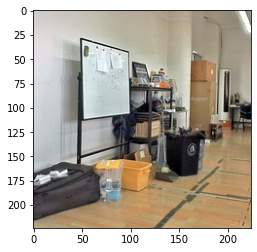

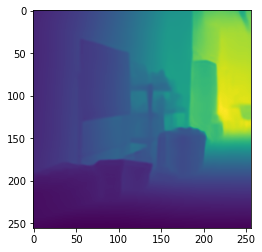

In [13]:
from pathlib import Path
DATA_FOLDER = Path("/root/autodl-tmp/vlntj-ce")
rgb_path = DATA_FOLDER 
for rgb_img in tqdm(sorted(list(rgb_path.glob("*/rgb/*.png")))[0:5]):
    rgb = Image.open(rgb_img)
    
    depth_img = str(rgb_img).replace("/rgb/","/depth/")
    depth = Image.open(depth_img)
    depth = np.array(depth).astype(float)
    print(depth.max())

    plt.imshow(rgb)
    plt.show()
    plt.imshow(depth)
    plt.show()

Generate sub

In [22]:
import json
DATA_FOLDER = Path("/root/autodl-tmp/vlntj-ce")
instructions = [
    "Move forward to the black box. Turn right and forward to the white board. Walk into the office area. Turn right and stop before black chairs.", # 0
    "Turn left and cross several boxes on your right. Move close to the water dispenser and the printer, then stop.", # 1
    "Turn left. Move forward down the hallway until you see the guitar and block board. Head towards the guitar and stop.", # 2
    "Walk into the storage area. Walk right past the box. Wait before the cabinets.", # 3
    "Forward along the corridor. Turn right into the office. Forward and take a left at the shelf. Wait before the refrigerator.", # 4
    "Walk past several chairs on your left. Continue past the trash bin. Stop by the bookshelf.", # 5
    "Start from the office with a barrel-loaded water. Take a left and walk out the door into the corridor. Find a door on the right and stop.", # 6
    "Move forward into the lobby. Turn left and exit the lobby with a large door. Walk to the bulletin board and stop.", # 7
    "Enter the mechanical studio. Turn left and move forward alongside the green table. Stop before chairs.", # 8
    "Walk past the area towards a blue car. Wait before the shelf with many boxes.", # 9
    "Face the green workbench. Turn left and walk out the door. Walk through the red extinguisher and the blue umbrella. Stop by the door.", # 10
    "See the blackboard, move forward a few steps. Turn left until you see a large television. Wait there.", # 11
    "Walk into the office area and stop before the white board around cabinets.", # 12
]
# with open("instructions.json", "w") as f:
#     f.write(json.dumps(instructions, indent=2))
# with open(DATA_FOLDER/"instructions.json","r") as f:
#     instructions = json.loads(f.read())
sub_data = instruction_cut_clip([{"instruction_text": v} for v in instructions], refine=True, append_dot=False, split_func=nltk.sent_tokenize, keep_subs=True)
sub_instructions = [v["sub_instruction"] for v in sub_data]
for i in tqdm(range(13)):
    inst_path = DATA_FOLDER/"{}/inst/0.txt".format(i)
    sub_path = DATA_FOLDER/"{}/sub/0.txt".format(i)
    os.makedirs(inst_path.parent, exist_ok=True)
    os.makedirs(sub_path.parent, exist_ok=True)
    with open(inst_path, "w") as f:
        f.write(instructions[i])
    with open(sub_path, "w") as f:
        f.write("\n".join(sub_instructions[i]))

<function sent_tokenize at 0x7f1a11f61a60>


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

# Metrics

{'sr': [0.0], 'spl': [0.0], 'apa': [0.5294117647058824], 'ndtw': [0.0011660158482249539]}


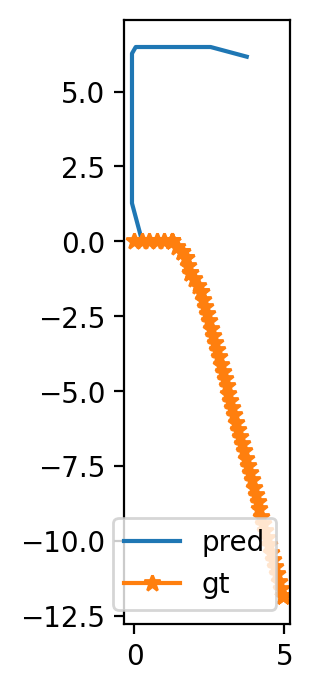

{'sr': [0.0, 0.0], 'spl': [0.0, 0.0], 'apa': [0.5294117647058824, 0.696969696969697], 'ndtw': [0.0011660158482249539, 0.12296748310739518]}


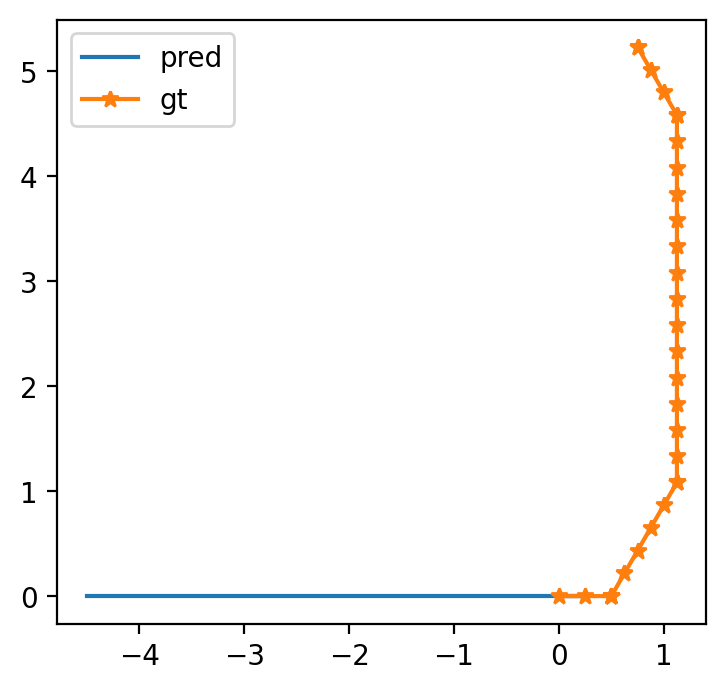

{'sr': [0.0, 0.0, 0.0], 'spl': [0.0, 0.0, 0.0], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793]}


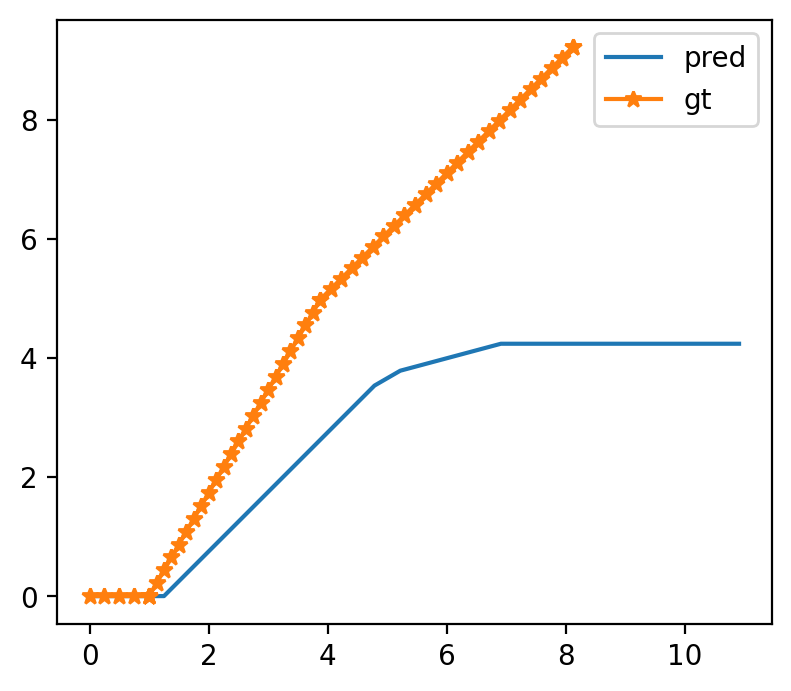

{'sr': [0.0, 0.0, 0.0, 0.0], 'spl': [0.0, 0.0, 0.0, 0.0], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565]}


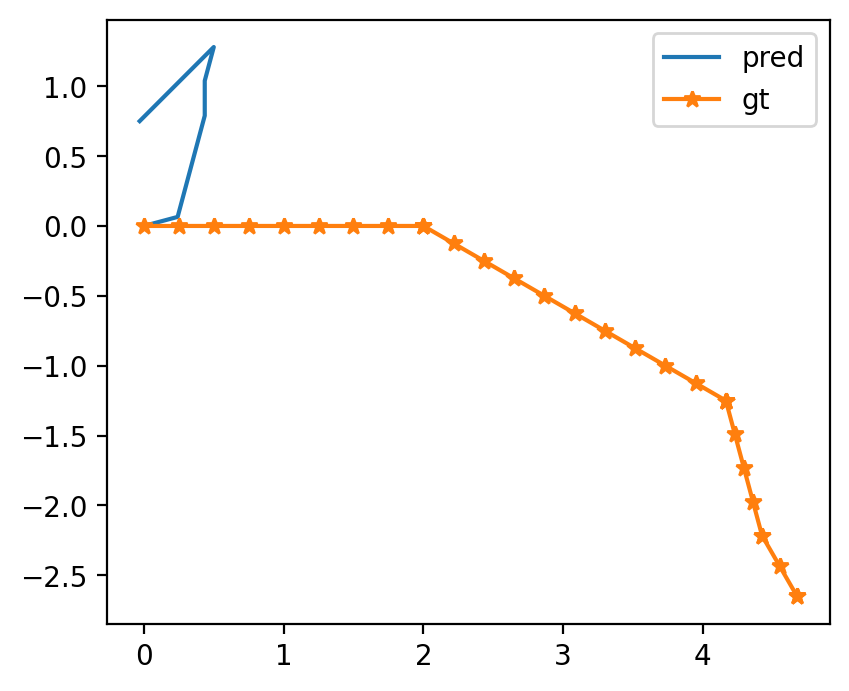

{'sr': [0.0, 0.0, 0.0, 0.0, 0.0], 'spl': [0.0, 0.0, 0.0, 0.0, 0.0], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613, 0.5], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565, 0.01862577795191361]}


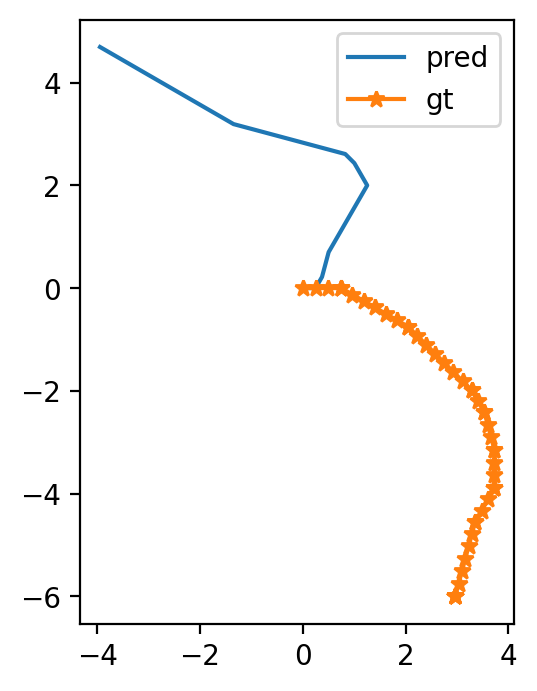

{'sr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'spl': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613, 0.5, 0.7058823529411765], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565, 0.01862577795191361, 0.28871085358827653]}


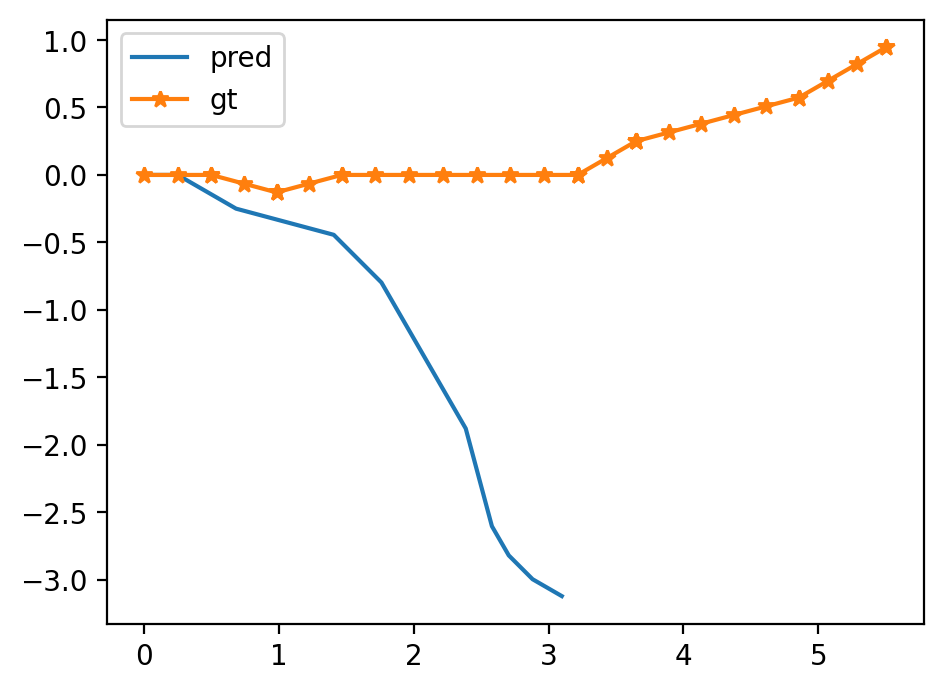

{'sr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'spl': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613, 0.5, 0.7058823529411765, 0.7884615384615384], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565, 0.01862577795191361, 0.28871085358827653, 0.1372265277373406]}


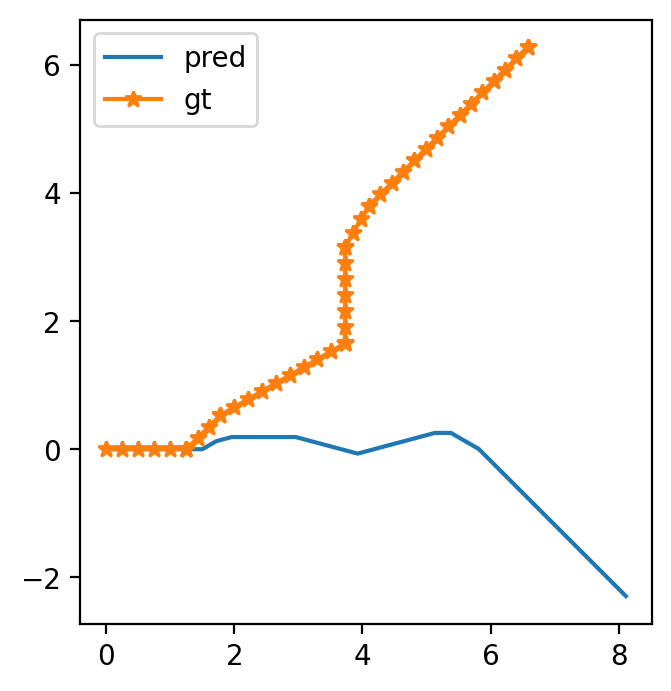

{'sr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'spl': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613, 0.5, 0.7058823529411765, 0.7884615384615384, 0.9], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565, 0.01862577795191361, 0.28871085358827653, 0.1372265277373406, 0.5941232386879767]}


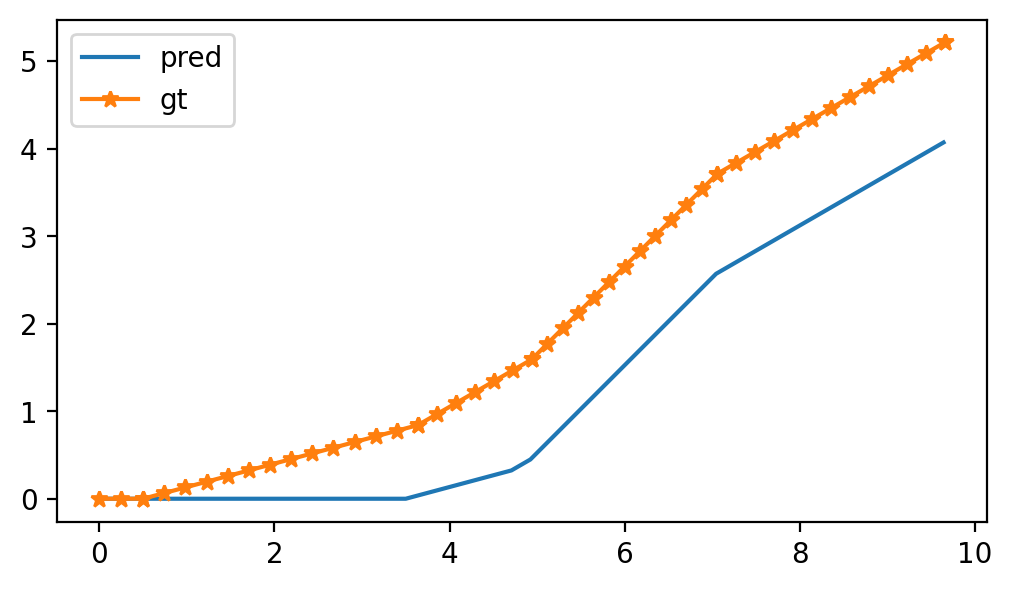

{'sr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], 'spl': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613, 0.5, 0.7058823529411765, 0.7884615384615384, 0.9, 0.6511627906976745], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565, 0.01862577795191361, 0.28871085358827653, 0.1372265277373406, 0.5941232386879767, 0.0679539648687326]}


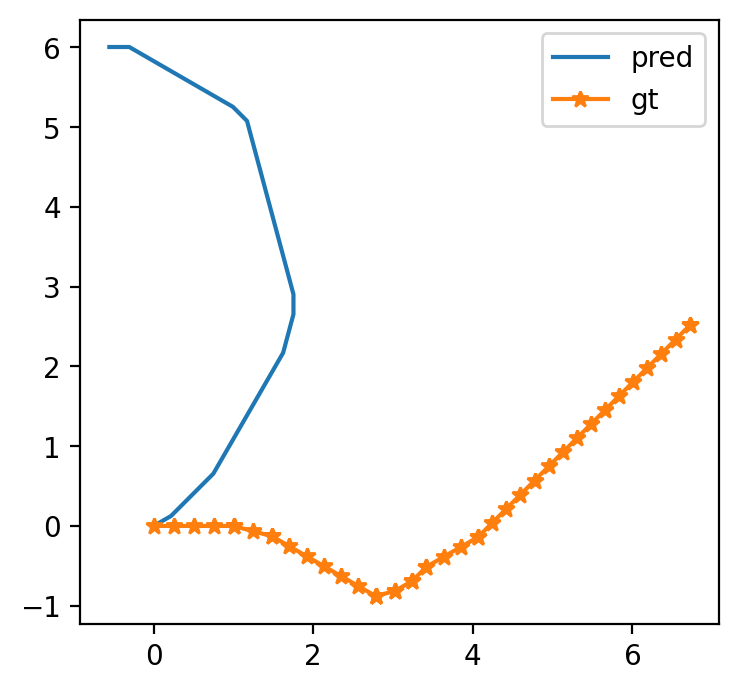

{'sr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 'spl': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.9090909090909091], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613, 0.5, 0.7058823529411765, 0.7884615384615384, 0.9, 0.6511627906976745, 0.9130434782608695], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565, 0.01862577795191361, 0.28871085358827653, 0.1372265277373406, 0.5941232386879767, 0.0679539648687326, 0.9167866781389539]}


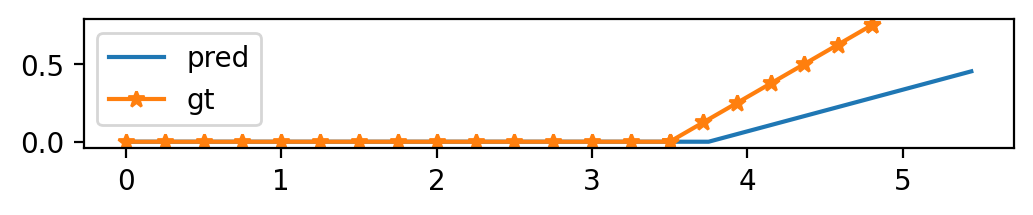

{'sr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], 'spl': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.9090909090909091, 0.9523809523809522], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613, 0.5, 0.7058823529411765, 0.7884615384615384, 0.9, 0.6511627906976745, 0.9130434782608695, 0.8333333333333334], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565, 0.01862577795191361, 0.28871085358827653, 0.1372265277373406, 0.5941232386879767, 0.0679539648687326, 0.9167866781389539, 0.752086264939557]}


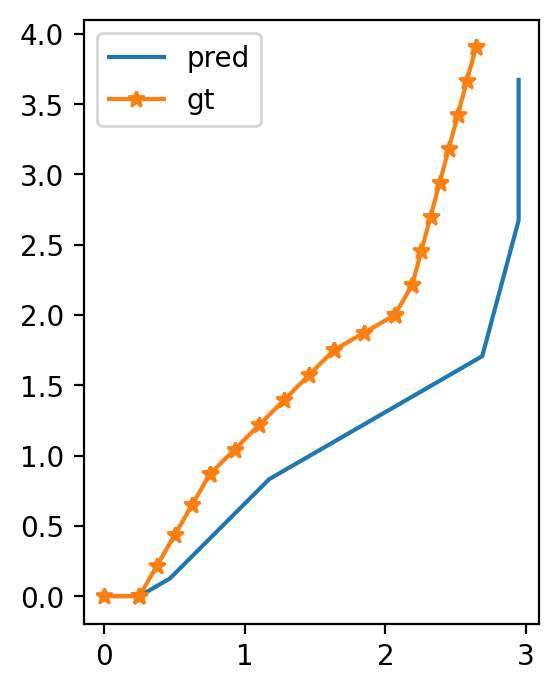

{'sr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0], 'spl': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.9090909090909091, 0.9523809523809522, 0.0], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613, 0.5, 0.7058823529411765, 0.7884615384615384, 0.9, 0.6511627906976745, 0.9130434782608695, 0.8333333333333334, 0.25], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565, 0.01862577795191361, 0.28871085358827653, 0.1372265277373406, 0.5941232386879767, 0.0679539648687326, 0.9167866781389539, 0.752086264939557, 0.07474133906624388]}


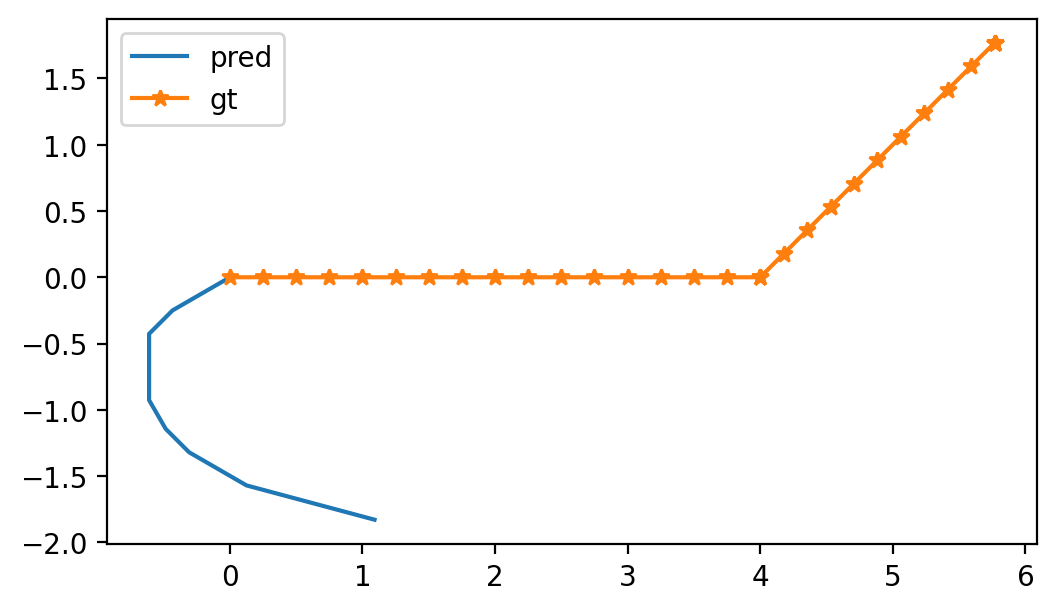

{'sr': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0], 'spl': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.9090909090909091, 0.9523809523809522, 0.0, 0.0], 'apa': [0.5294117647058824, 0.696969696969697, 0.9473684210526315, 0.2903225806451613, 0.5, 0.7058823529411765, 0.7884615384615384, 0.9, 0.6511627906976745, 0.9130434782608695, 0.8333333333333334, 0.25, 0.25806451612903225], 'ndtw': [0.0011660158482249539, 0.12296748310739518, 0.2547675324336793, 0.1251804101877565, 0.01862577795191361, 0.28871085358827653, 0.1372265277373406, 0.5941232386879767, 0.0679539648687326, 0.9167866781389539, 0.752086264939557, 0.07474133906624388, 0.11693092122586002]}


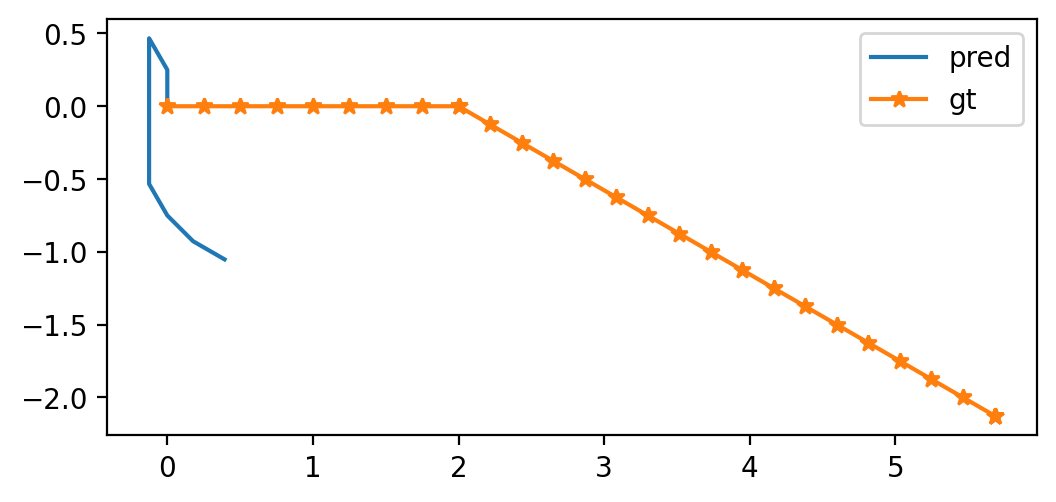

In [13]:
DATA_FOLDER = Path("/root/autodl-tmp/vlntj-ce6+36")
EPISODE_NUM = 13
import math
import numpy as np
from dtw import dtw
FORWARD = 1
TURN_LEFT = 2
TURN_RIGHT = 3
def euclidean_distance(
    pos_a, pos_b
) -> float:
    return np.linalg.norm(np.array(pos_b) - np.array(pos_a), ord=2)
class Metrics:
    def __init__(self, pred_action, gt_action):
        self.sr_threshold = 1.5
        self.turn_angle = 15

        self.pred_action = pred_action
        self.gt_action = gt_action
        self.pred_position, self.pred_heading = self.calc_pos(pred_action)
        self.gt_position, self.gt_heading = self.calc_pos(gt_action)

    def calc_pos(self, action):
        current_position = (0.0, 0.0)
        current_heading = 0
        res_position = [current_position]
        res_heading = [current_heading]
        for a in action:
            if a==1:
                dx = 0.25 * np.cos(np.deg2rad(current_heading))
                dy = 0.25 * np.sin(np.deg2rad(current_heading))
                current_position = (current_position[0]+dx, current_position[1]+dy)
                # print(np.sqrt(dx*dx+dy*dy))
            elif a==2:
                dw = self.turn_angle
                current_heading = current_heading + dw
                if current_heading>=360:
                    current_heading = current_heading-360
            elif a==3:
                dw = -self.turn_angle
                current_heading = current_heading + dw
                if current_heading<0:
                    current_heading = current_heading+360
            res_position.append(current_position)
            res_heading.append(current_heading)
        return res_position, res_heading
    def calc_len(self, position):
        coors = np.array(position)
        diff = coors[:-1]-coors[1:]
        dist = np.sum(np.linalg.norm(diff, axis=1, ord=2))
        return dist
    def calc_sr(self):
        pred_coor = self.pred_position[-1]
        gt_coor = self.gt_position[-1]
        diff = np.array(pred_coor)-np.array(gt_coor)
        dist = np.linalg.norm(diff, ord=2)
        if dist<=self.sr_threshold:
            return 1.0
        else:
            return 0.0
    def calc_spl(self):
        sr = self.calc_sr()
        pred_l = self.calc_len(self.pred_position)
        gt_l = self.calc_len(self.gt_position)
        spl = sr*gt_l/max(pred_l, gt_l)
        return spl
    def calc_apa(self):
        pred_action = np.array(self.pred_action, dtype=int)
        gt_action = np.array(self.gt_action, dtype=int)
        return np.sum(pred_action==gt_action)/len(gt_action)
    def calc_ndtw(self):
        dtw_distance = dtw(
            self.pred_position, self.gt_position, dist=euclidean_distance
        )[0]

        nDTW = np.exp(
            -dtw_distance
            / (len(self.pred_position) * self.sr_threshold)
        )
        return nDTW
    def plot_pos(self):
        plt.figure(dpi=200)
        pred_position = np.array(self.pred_position)
        gt_position = np.array(self.gt_position)
        # print(self.gt_action)
        # print(self.pred_action)
        # print(self.gt_heading)
        plt.plot(pred_position[:,0], pred_position[:,1])
        plt.plot(gt_position[:,0], gt_position[:,1], marker="*")
        plt.legend(["pred","gt"])
        plt.axis('scaled')
        plt.show()

    # def calc_ape(self):
results = {
    "sr":[],
    "spl": [],
    "apa": [],
    "ndtw": [],
}
for i in range(EPISODE_NUM):
    episode_folder = DATA_FOLDER / str(i)
    with open(episode_folder/"action"/"action.json", "r") as f:
        gt_action = json.loads(f.read())
    with open(episode_folder/"pred_action"/"pred_action.json", "r") as f:
        pred_action = json.loads(f.read())
    metrics = Metrics(pred_action, gt_action)
    results["sr"].append(metrics.calc_sr())
    results["spl"].append(metrics.calc_spl())
    results["apa"].append(metrics.calc_apa())
    results["ndtw"].append(metrics.calc_ndtw())
    print(results)
    metrics.plot_pos()

In [17]:
# random
DATA_FOLDER = Path("/root/autodl-tmp/vlntj-ce13+39")
results = {
    "sr":[],
    "spl": [],
    "apa": [],
    "ndtw": [],
}
for i in range(EPISODE_NUM):
    episode_folder = DATA_FOLDER / str(i)
    with open(episode_folder/"action"/"action.json", "r") as f:
        gt_action = json.loads(f.read())
    pred_action = np.random.randint(0,4,size=(len(gt_action,)))
    pred_action = list(pred_action)
    metrics = Metrics(pred_action, gt_action)
    results["sr"].append(metrics.calc_sr())
    results["spl"].append(metrics.calc_spl())
    results["apa"].append(metrics.calc_apa())
    results["ndtw"].append(metrics.calc_ndtw())
for k in results:
    results[k] = np.mean(results[k])

results_random = results
print(results_random)

# half tune
DATA_FOLDER = Path("/root/autodl-tmp/vlntj-ce6+36")
results = {
    "sr":[],
    "spl": [],
    "apa": [],
    "ndtw": [],
}
for i in range(EPISODE_NUM):
    episode_folder = DATA_FOLDER / str(i)
    with open(episode_folder/"action"/"action.json", "r") as f:
        gt_action = json.loads(f.read())
    with open(episode_folder/"pred_action"/"pred_action.json", "r") as f:
        pred_action = json.loads(f.read())
    metrics = Metrics(pred_action, gt_action)
    results["sr"].append(metrics.calc_sr())
    results["spl"].append(metrics.calc_spl())
    results["apa"].append(metrics.calc_apa())
    results["ndtw"].append(metrics.calc_ndtw())
for k in results:
    results[k] = np.mean(results[k])
results_half_tune = results
results_half_tune = {'sr': 0.3076923076923077,
 'spl': 0.30402930402930406,
 'apa': 0.6098191345660883,
 'ndtw': 0.35089457130354035}

# full tune
DATA_FOLDER = Path("/root/autodl-tmp/vlntj-ce13+39")
results = {
    "sr":[],
    "spl": [],
    "apa": [],
    "ndtw": [],
}
for i in range(EPISODE_NUM):
    episode_folder = DATA_FOLDER / str(i)
    with open(episode_folder/"action"/"action.json", "r") as f:
        gt_action = json.loads(f.read())
    with open(episode_folder/"pred_action"/"pred_action.json", "r") as f:
        pred_action = json.loads(f.read())
    metrics = Metrics(pred_action, gt_action)
    results["sr"].append(metrics.calc_sr())
    results["spl"].append(metrics.calc_spl())
    results["apa"].append(metrics.calc_apa())
    results["ndtw"].append(metrics.calc_ndtw())
for k in results:
    results[k] = np.mean(results[k])
results_full_tune = results
results_full_tune = {'sr': 0.38461538461538464,
 'spl': 0.3687002652519894,
 'apa': 0.7720373165566047,
 'ndtw': 0.49541305655582263}

{'sr': 0.0, 'spl': 0.0, 'apa': 0.2872620334098509, 'ndtw': 0.2271574401692977}


/tmp/ipykernel_275693/1609571455.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


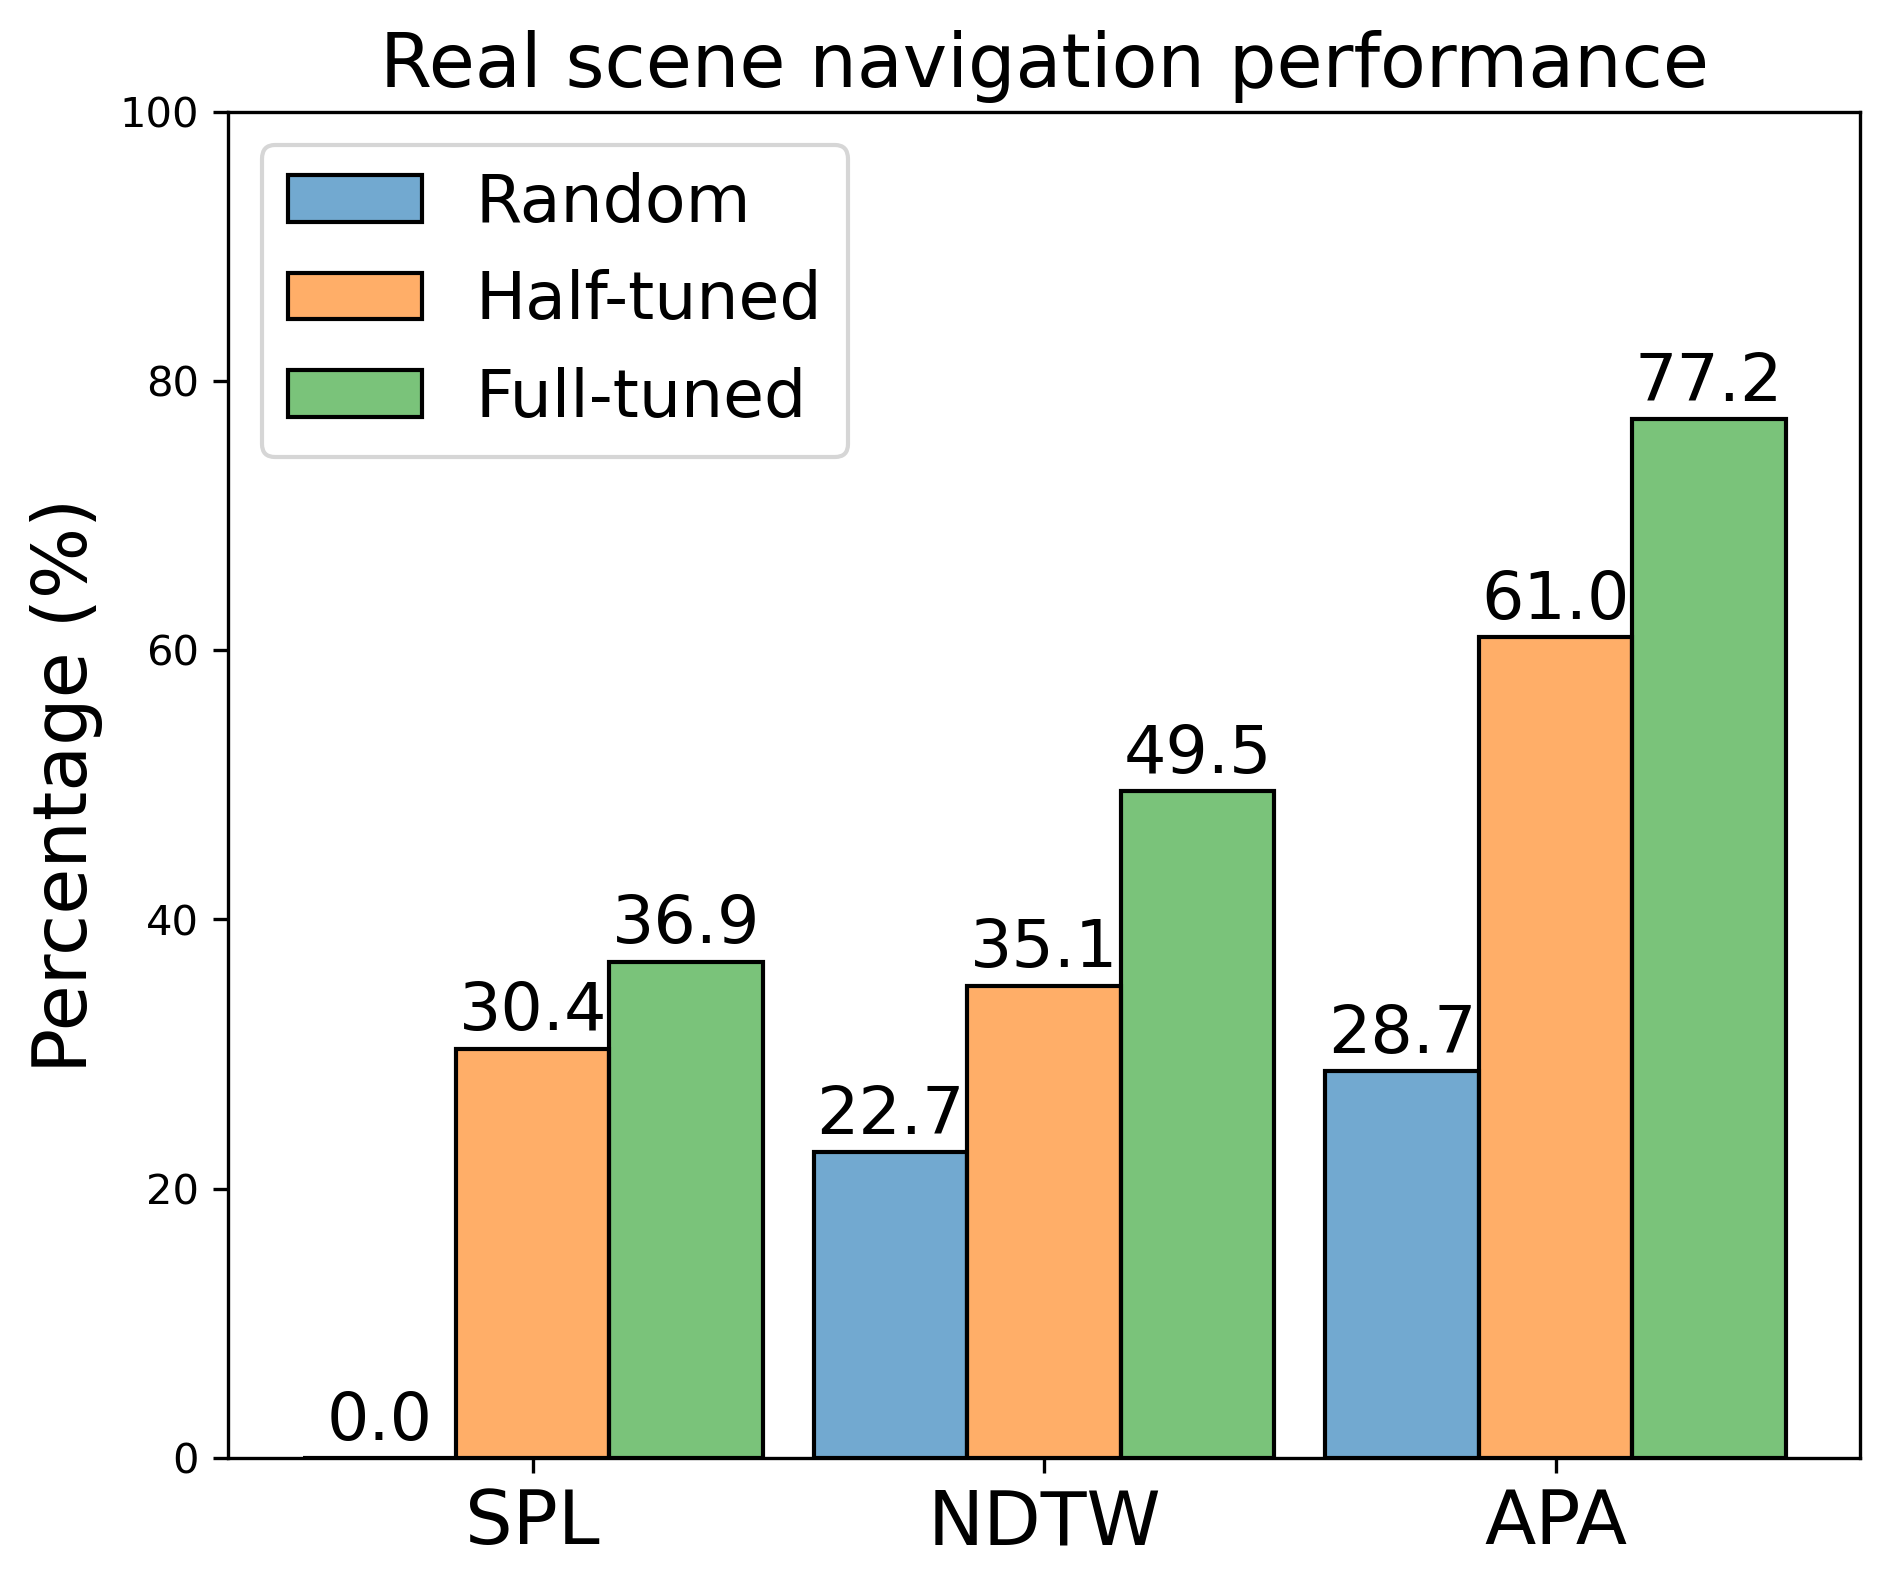

In [32]:
import matplotlib.pyplot as plt
import numpy as np

FS = 18
species = ("SPL", "NDTW", "APA", )
penguin_means = {
    'Random': np.array([results_random["spl"], results_random["ndtw"], results_random["apa"]])*100,
    'Half-tuned': np.array([results_half_tune["spl"], results_half_tune["ndtw"], results_half_tune["apa"]])*100,
    'Full-tuned': np.array([results_full_tune["spl"], results_full_tune["ndtw"], results_full_tune["apa"]])*100,
}

x = np.arange(len(species))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',dpi=300, figsize=(6.4,5.4))
colors = plt.cm.viridis(np.array([0.0, 0.5, 1.0]))
for i in range(3):
    colors[i][3] = 0.5
colors = ['#1f77b4a0', '#ff7f0ea0', '#2ca02ca0']
for i, (attribute, measurement) in enumerate(penguin_means.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, color=colors[i], edgecolor="black")
    ax.bar_label(rects, fmt="%.1f", padding=1, fontsize=FS-2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage (%)', fontsize=FS)
ax.set_title('Real scene navigation performance', fontsize=FS)
ax.set_xticks(x + width, species, fontsize=FS)
ax.legend(loc='upper left', ncols=1, prop={'size': FS-2})
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig("real_scene.pdf", dpi=300, bbox_inches="tight", pad_inches=0)
plt.savefig("real_scene.svg", dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()

In [21]:
a = []
for metrics in best_metrics:
    a.append(metrics.pred_action)
with open("best_metrics_half_tuned.json","w") as f:
    f.write(json.dumps(a))

In [25]:
for i in range(13):
    path = DATA_FOLDER / str(i) /"pred_action"/"pred_action.json"
    with open(path, "w") as f:
        f.write(json.dumps(a[i]))